In [1]:
# general imports usually needed
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd

In [2]:
# libraries more specific to this lecture notebook
# it is good practice that all imports for most working notebooks usually go at the 
# beginning.  When learning about libraries like scikit-learn, I will put the imports 
# at the top, but also demonstrate and re-import the library where discussed below in the 
# notebook.
import os
import tarfile
import urllib
import matplotlib.image as mpimg

In [3]:
# notebook wide settings to make plots more readable and visually better to understand
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', titlesize=18)
mpl.rcParams['figure.figsize'] = (10.0, 8.0) # default figure size if not specified in plot

# 2. (Chapter 2) End-to-End Machine Learning Project

This chapter is really more of a big-picture discussion and some motivation and showing off of the 
power that some of the tools of the scientific Python stack can give you when applied to 
machine learning modeling.  

This is a good chapter to come back to after you finish this course.  If you stive to be a ML
data scientist or practioner, you will spend a lot of your time doing data acquisition, data cleaning,
and data exploration.  Maybe even more than doing actual ML training and modeling.  The data acquisition 
and cleaning part is just as important, if not more so, than the modeling and tuning.

In this course we mainly concentrate on learning about the various ML models and techniques.  Thus 
we necessarily kind of skip over data cleaning and exploration in this course.  In this chapter you will 
get a little flavor of these necessary preliminary steps to being a data scientist.


## 2.1 The Big Picture

The data used for the example in this chapter is medium size, but relatively realistic.  The made up task is 
to try and build a model of housing prices using publically available census bureau data.  The data is 
restricted to districts in california.  

I will not comment too much on the big picture goals and ideas introduced in this chapter about working with 
this data to build a model of housing prices.  But suffices to say, as a real working data scientist, 
this would be the kind of workflow and questions you would need to keep in mind while doing your job. 
As introduced in this section, you need to carefully fame the problem, select your measures of performance 
and models you will use carefully, and check your assumptions, to be a successful data scientist.

Before we get into the data, let me make a note of the common Notations introduced in the alert box on 
page 42.  The vast majority of time we will work conceptually with a table of data.  The data contains 
$m$ rows of instances or samples of data, and $n$ columns of attribute features.

**Notations**

$m$ is the number of instances in the dataset you are working with.  For example in our California housing 
dataset below there are a total of 20640 rows in the full data set, representing 20640 sampled housing 
districts.

Each row has the same set of $n$ features.  The textbook introduces the notation of a vector $x^{(i)}$ where
$i$ is simply an index to get the $i^{th}$ instance in the dataset.  In Python `numpy` arrays this translates
into the index of the row, and the second index can be used to select a particular feature column.  For example
below after we load the housing data into a `pandas` `DataFrame`, the `housing` variable has the following 
shape:

```python
>>> housing.shape
(20640, 10)
```

This means there are 20640 rows or samples to this data.  Thus $m = 20640$ in this data set.  There are 
currently 10 columns, though one of these columns will actually be pulled out to form the training labels.
But currently $n = 10$.

We can thus access the $5^{th}$ instance of the data using array indexing.  If `X` is a regular `numpy` 
array, we sould simply do `X[5]` to get the $5^{th}$ sample.  `housing` is a `pandas` `DataFrame` so we 
need to use the `.iloc[]` accessor to access by array index:

```python
>>> housing.iloc[5]
longitude              -122.25
latitude                 37.85
housing_median_age          52
total_rooms                919
total_bedrooms             213
population                 413
households                 193
median_income           4.0368
median_house_value      269700
ocean_proximity       NEAR BAY
Name: 5, dtype: object
```


We can use the column index to access features.  In `pandas` `DataFrame` objects, we can access the 
columns by name:

```python
>>> # get the total_rooms of the first 5 districts
>>> housing['total_rooms'].iloc[:5]
0     880.0
1    7099.0
2    1467.0
3    1274.0
4    1627.0
Name: total_rooms, dtype: float64
```

```python
>>> # same thing but using fact that total_rooms is the 3rd column of the dataframe
>>> housing.iloc[:5, 3]
0     880.0
1    7099.0
2    1467.0
3    1274.0
4    1627.0
Name: total_rooms, dtype: float64
```

If X is a numpy array instead, we would using array indexing to get this information
```python
>>> # if X is a numpy array, slice first 5 samples, and only the column 3 of the data
>>> X[:5, 3]
```


Traditionally `X` is the name given to the array of the table of input data (`m` rows of samples by `n` 
columns of features).  `y` is typically a vector of size `m` which contains the labels of the 
samples in `X` we want to model.  For our housing data, we will pull out the labels using the median
housing price
```python
>>> housing_labels = housing['median_house_value'].copy()
>>> housing_labels.shape
(20640,)
```

The resulting vector has 1 label for each of the 20640 samples, and for example the label for sample 5 
is found in the `housing_labels` vector at index 5
```python
>>> housing_labels[5]
269700.0
```

$h$ is the prediction function we are trying to obtain, also called a _hypothesis_.  Once we have trained a 
ML model, given an instances feature vector $x^{(i)}$, the hypothesis function outputs a predicted value
(called y-hat) $\hat{y}^{(i)} = h(x^{(i)})$

The difference between the predicted value and the label is your prediction error:
$\text{error} = \hat{y}^{(i)} - y^{(i)}$

As we will discuss a bit below, a common performance measure for predicting a real valued number like the 
prices of a house is to use the root mean squared error, or $RMSE$.  It is really the magnitude of the 
error that is of interest, we don't care if we guessed too low or too high, just how far away we were 
from the actual house price.  You can get the magnitude by using the absolute value.  Another way is to 
square the error.  The $RMSE$ is a measure of the overall performance of our hypothesis function $h$.
It is measued as:

$$
RMSE(X, h) = \sqrt{ \frac{1}{m} \sum_{i=0}^m \big(\hat{y}^{(i)} - y^{(i)} \big)^2 }
$$

This is our fist example of a cost function, also known as a fitness function.  Recall that 
$\hat{y}^{(i)} = h(x^{(i)})$.  So the $RMSE$ is the sum of the squared differences between 
the hypothesis and the true answer.  We average this sum by dividing by $m$.  Then we take the 
square root of this average.  The result is the average amount of error we get for the 
given hypothesis function $h$.  And in this case, since an error of 0 means perfect prediction
for all of the samples, the closer the $RMSE$ is to 0, the better our hypothesis function
$h$ is performing.

## 2.2 Get the Data

In this section we get the data and perform some initial data exploration and visualization.  We deemphasize 
these tasks in this course, but in real data analytics work you spend a lot if not most of your time gathering,
acquiring, cleaning and exploring data, before you ever use it to build models with.

Good standard practice for data analytics projects is that all data resides in a common data directory.
Notice the data directory is specified relative to this working notebook.

This particular dataset is not so big, but nonetheless we do not keep the raw data in our repository.  This is not 
uncommon, especially for truly large datasets.  Data for large data sets is normally kept in a separate store, 
and is only brought into the local disk or into local memory as needed in chunks.  

The below procedure illustrates this process to some extent.  We download the raw from the source and save it 
locally to disk.  The download is only performed if the `housing.csv` resulting raw data file is not present.
Otherwise the download and extraction are skipped.  This makes this notebook rerunable without having the 
raw data transferred everytime the notebook is run.

A `csv` file is a comma separated file of values (or features as we just called them above).  You should 
open up the resulting `housing.csv` file in a text editor and make sure you understand how the resulting
data frame is loaded into python/pandas.

`csv` files are the simplest format of files used in data analytics, but are still very common, especially
in training or tutorial settings.  For a real data project, most likely your data set is much larger, and 
it will often reside in an sql or nosql database that you would query or sample from to get an in core 
sample of the dataset for exploration and processing.

In [4]:
# define global constants for acquiring data.  In a real project structure, we might abstract these
# constants to files in the project packages to be used throughout the project
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = '../data'
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

In [5]:
def download_progress_hook(count, block_size, total_size):
    """Hook for urlretrieve so we can monitor progress of 
    downloads.
    """
    total_received = count * block_size
    print("Received %8d / %8d bytes" % (total_received, total_size), end='\r', flush=True)
    
    
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """Fetch the chapter 2 example housing data.  The default download url
    and location to fetch the tared and gzipped data file are assumed to be 
    the declared constants above.
    """
    # do nothing if the file is already downloaded
    csv_filename = os.path.join(housing_path, 'housing.csv')
    if os.path.isfile(csv_filename):
        print("Downloaded data file exists, nothing done.")
        return
    
    # make sure the data directory exists
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    
    # filename of resulting tared and gziped file we will download
    tgz_filename = os.path.join(housing_path, 'housing.tgz')
    
    # actually download the file
    if not os.path.isfile(tgz_filename):
        urllib.request.urlretrieve(housing_url, tgz_filename, reporthook=download_progress_hook)
        print('')
        print('File successfully downloaded')
    
    # extract the tared and gzipped file to the data directory
    if not os.path.isfile(csv_filename):
        housing_tgz = tarfile.open(tgz_filename)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()
        print('Data successfully extracted')
        
        # remove compressed file so doesn't waste space
        os.remove(tgz_filename)

In [6]:
fetch_housing_data()

Downloaded data file exists, nothing done.


In [7]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [8]:
housing = load_housing_data()

The result of the download ad the load function is a `pandas` `DataFrame` object.  As discussed above,
the resulting table of data contains $m = 20640$ features.  The raw data has $n = 10$ columns, thogh 
we will extract the `median_house_value` as our label later, and will do some data cleaning and 
transformations of some of the other columns below.

In [9]:
# the shape currently of the raw housing data
# m = 20640 rows or samples in the data set
# n = 10 columns or features, though the feature median_house_value is actually the label we will take out and 
# use later for training
print(housing.shape)

(20640, 10)


In [10]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [11]:
# Example to get the 5th sample of the data set
housing.iloc[5]

longitude              -122.25
latitude                 37.85
housing_median_age        52.0
total_rooms              919.0
total_bedrooms           213.0
population               413.0
households               193.0
median_income           4.0368
median_house_value    269700.0
ocean_proximity       NEAR BAY
Name: 5, dtype: object

In [12]:
# access a column feature, for example the total_rooms for the first 5 districts
housing['total_rooms'].iloc[:5]

0     880.0
1    7099.0
2    1467.0
3    1274.0
4    1627.0
Name: total_rooms, dtype: float64

In [13]:
# same thing but using fact that total_rooms is the 3rd column
housing.iloc[:5, 3]

0     880.0
1    7099.0
2    1467.0
3    1274.0
4    1627.0
Name: total_rooms, dtype: float64

In [14]:
# we will later extract the median_house_value to act as labels for our supervised
# machine learning model
housing_labels = housing['median_house_value'].copy()
housing_labels.shape

(20640,)

In [15]:
type(housing_labels)

pandas.core.series.Series

In [16]:
# the label for the 5th district correpsonds to the median house value for this district, this would be the 
# target value we want our model to predict for a house in a district with similar features to this district
housing_labels[5]

269700.0

### Take a Quick Look at the Data

Some more examples of data exploration.  These are typical tasks one would do when first acquiring and trying 
to learn about the features of a new data set.  We are depending on `pandas` library features for a lot of the 
exploration below.  We use functions like `head()` and `info()` from `pandas` data frames to get summary 
information about the data.

We also might use some of the quick plotting/visualization features built into pandas data frames to quickly 
get a handle on our dataset.  For example, plotting histograms of the numerical attributes to get a feel 
for their distribution.

In [17]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [18]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


All of the attributes except the last one `ocean_proximity` are numerical attributes.  Though some attributes
are integers, and some are more specific types like `longitude` and `latitude`.

`ocean_proximity` is an example of a categorical variable.  These are common in data sets.  In this case, 
the categorical variable is a finite category, there is only a small defined set of values for the category.
We can use the `value_counts()` function of `panda` `DataFrame` to get a feel for the categories and their 
distributions.


In [19]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

The values are actually strings currently, which is what a `dtype` of `object` will get you if string attributes 
are read in using the `read_csv()` function of `pandas`.  The categories in this case look relatively clean, e.g.
we don't have variations like 'INLAND', 'IN LAND', etc. we might expect if people are allowed to enter in text 
freely for an attribute like this.

We will later have to convert this categorical attribute to a numerical value using a mapping like 0 for `INLAND`,
1 for `NEAR OCEAN`, etc., as most ML models cannot use textual attributes when fitting a model to the training 
data.

For numerical data, we can get a feel for the distribution of the attributes by calculating their mean, 
variance and the percentile ranges.  The `describe()` function of `pandas` `DataFrame` performs this on
all numeric attribute types:

In [20]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


You should make special note of the count here.  The count is of the non empty or non-null entries for each 
attribute.  So the `total_bedrooms` differs from the other numerical attributes here.  This is because we have 
some missing entries in the `total_bedrooms` attribute, some of the entries were null or not entered.  We will 
have to deal with this missing data at some point.

For a real data set, we might also want to check if any of the non numerical attributes have missing data 
as well while making our preliminary data exploration.  Since we only have a single categorical attribute, we 
could just sum up the counts we had before and see if it equals our sample count $m$ or not:

In [21]:
housing['ocean_proximity'].value_counts().sum()

20640

In this case there are no missing entries for the `ocean_proximity` attribute.  It is actually pretty rare for 
a real raw dataset to have only 1 attribute with some missing data, and not very missing attributes at that.
Missing values are often a big issue that have to be dealt with as one of the first steps in data cleaning.

Finally, as an example of using some of the quick visualizaitons of `pandas` `DataFrame` objects, we can get
histograms of the numerical attributes.  This gives a better feel than the raw numbers and percentiles 
shown by `describe()` of the distributions of our numerical attributes.

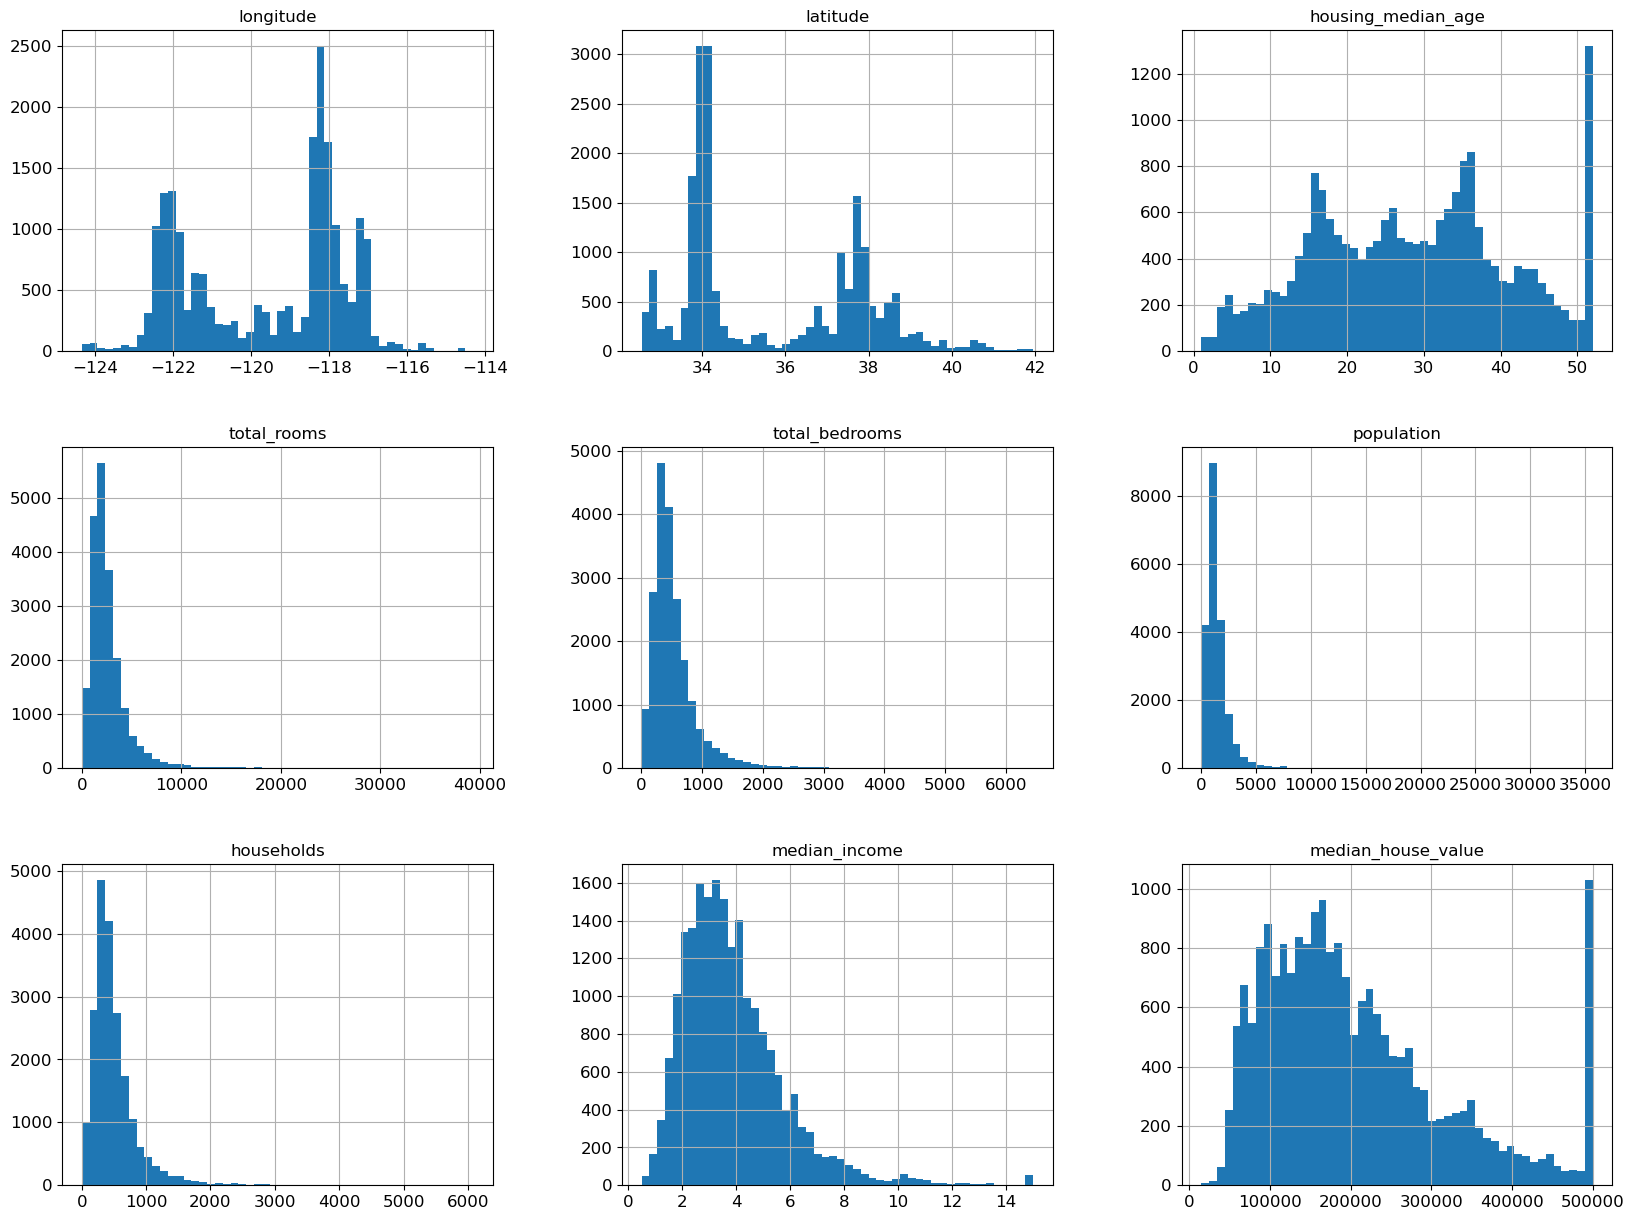

In [22]:
housing.hist(bins=50, figsize=(20,15));

Some other things that one should notice from a preliminary investigation like this:

1. Median income looks funny if we know something about income in a state like California in the US.  A good 
assumption is that this is given in \\$10k of dollars, thus we see median incomes centered around \\$30k to 
\\$40k.  This is not quite the representation used here, the data was scaled from 1 to 15, but the effect is
that you can roughly map the scaled values as described to \\$10k here.  Working with preprocessed attributes 
like this is common for real data sets.
2. Notice the big bar/bin the final value for `housing_median_age` and `median_house_value`.  This is typical if values are 
capped during data collection.  Here any valu larger than 50 for the median age for a house was entered as
50, and any value greather than \\$500k for median house value was capped to \\$500k.  Thus you see an 
inordinately large bin for the last value in the histogram.  As noted in our text, this could especially be 
problematic for the `median_house_value` which is the label we want to predict.  Thus we have no real data 
to train with representing median house values greater than the cap, so we would not expect our model to be 
able to predict well districts like this if we use this raw data.
3. The attributes have very different scales.  Income ranges only from 0 to 15, but house value goes from 0 to 
500,000.  Different scales like this are problems for some machine learning models, and thus we may need to scale
attributes like these with widely different ranges to have a common similar range of values.
4. Many histograms are tail heavy, they extend much further to the right of the median than to the left.  Again 
some machine learning models don't deal well with non normal distributions like this, and thus again a scaling into 
a more bell-shaped normal distribution can help in those cases.

## 2.3 Discover and Visualize the Data to Gain Insights

So far we have been performing some preliminary exploration.  In exploration we answer questions about what 
attributes we have, what are their distributions, which attributes are missing data, what categorical 
attributes do we have, what kinds of scaling and transformations will we need to perform.

Here the goal is to go a little more in depth.  Actually this step might be done here or might be done after
training models, when readying final reports and presentations of findings.

In textbook the following visualizations were done on only the training data.  Here we change a bit and 
create a visualizaiton using all the data, as the purpose really is for human consumption, to be able to 
better visualizae and see trends in this data set.

### Visualizing Geographical Data

We start by still using the build in `pandas` plotting and visualization.  The `plot()` function for a
`DataFrame` can make different kinds of plots.  For a geographical plot, we can start with the 
`longitude` and `latitude` attributes to represent our California housing districts on a map.

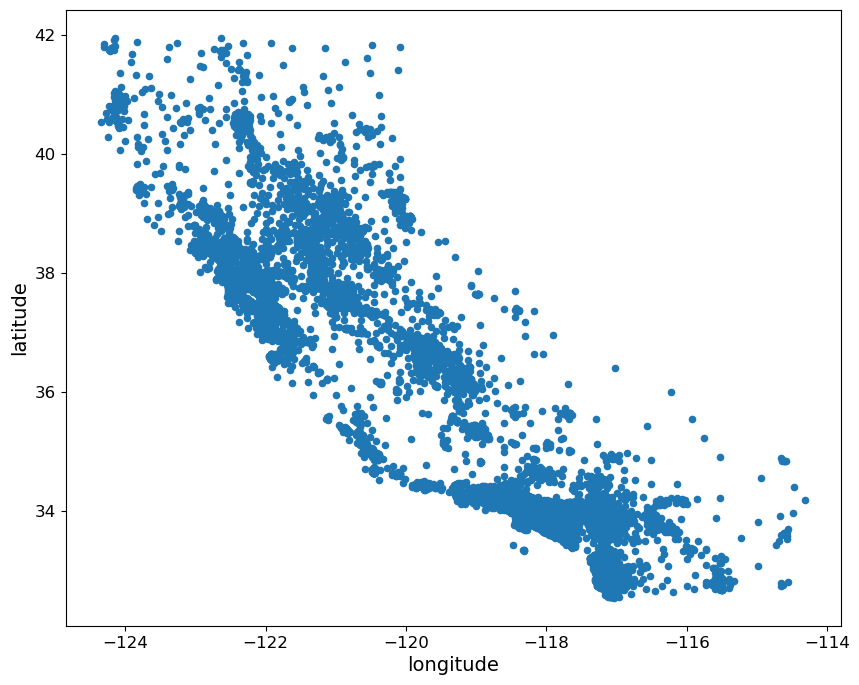

In [23]:
# visualize the geographical information of the data
housing.plot(kind='scatter', x='longitude', y='latitude');

This looks like California if you are familiar with the US state.  But a common problem for a scatter plot
of spatial data is that it is hard to get a sense of the density of the data.  Our dataset is still relatively 
small, but still looking at this you might think some of the inland mountain districts are as densly populated 
as Los Angeles and the Bay area.

A common trick in scatter plot visualizations to help see density of distributions is to use an alpha
(or transparency) setting for scatter points.  This allows points to be see through, and thus dense 
areas show up visually as more filled in.

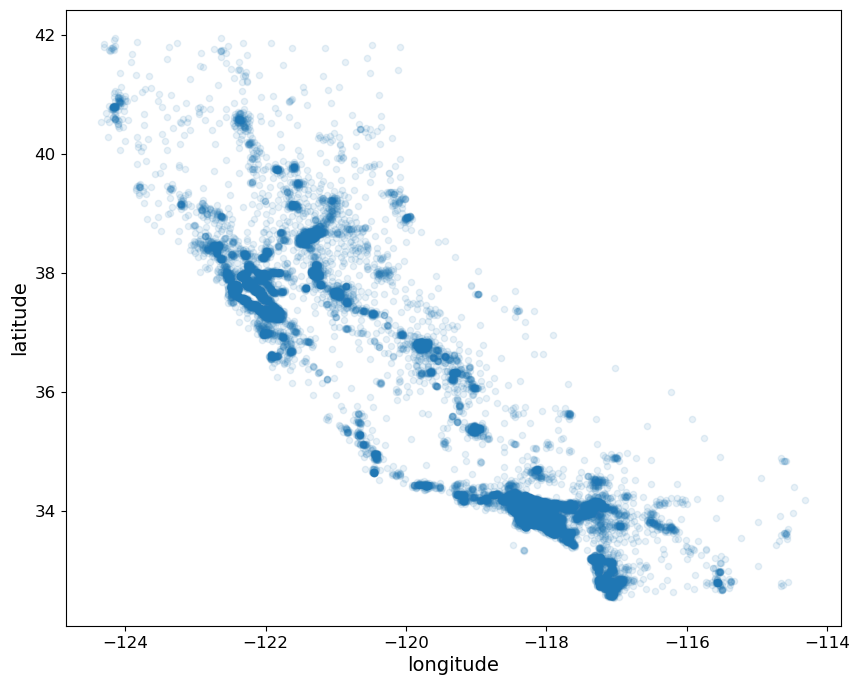

In [24]:
# visualize the geographical information of the data,
# use alpha so get better idea of density of the distribution
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1, figsize=(10,8));

This trick is pretty effective.  We can clearly see the dense Bay and Los Angeles
population areas on the coast, plus some fairly long line of high density in the 
area known as the Central Valley.  For even more dense plots, you can make the alpha value
even more transparent.

Lets finish the visualization by adding even more information.  This is a common trick
in visualization to represent more than 2 feature/attributes on a 2D plot.  Here we will 
add a color coding of the plots to represent our target label value, the 
`median_house_value`.  Because of the color map we use below, blue colors represent low 
cost median house values, while warmer up to red colors are the higher priced 
houses.  

We also add in a representation of the population size of our sample districts.  We set the 
size of the scatter plot marker based on population of the district.  So a large marker means 
a lot of people live in the district, and a small one means a small population.

Thus our figure now conveys not only the geographical location of the districts, and their 
density, but using color we convey the average house price ranges in the districts, and using 
marker size we get a sense of the district population size.

In the next figure, we modify the default size so that the plot is still the
same size as before, but now we have  a colorbar indicator as a key to the marker coloring.
We have also adjusted the alpyha because the color coding now helps with estimating 
density as well here.

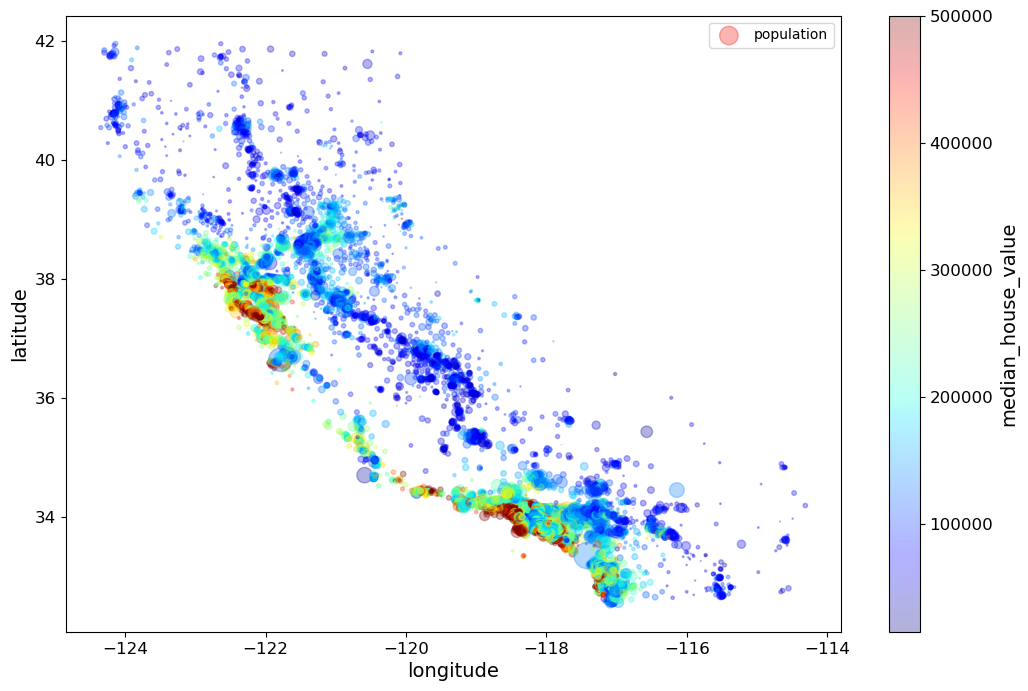

In [25]:
# radius of each circle represents population size, color represents price
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.3,
            s=housing['population']/100, label='population', figsize=(12.5,8),
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True,
            sharex=False)
plt.legend();

Finally, the above figure is pretty useful.  But if we want to present this in a report 
or for a presentation to our managers, we want to make it as easy to understand at a 
glance as possible.  We should plot the geographical data on an actaul map of 
the state of California for context.  We should also make sure all labels 
are meaningful to a casual viewer of the figure who is not familiar with the data.

We will load a map to use as background, and replot with better labels.  We might want to 
add a title.  This figure would then be useful for reporting, so we might want to save it 
as a static result to our `figures` subdirectory.


In [26]:
# Download the California image
PROJECT_ROOT_DIR='..' # root of project is 2 levels up from this notebook
images_path = os.path.join(PROJECT_ROOT_DIR, "figures")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('../figures/california.png', <http.client.HTTPMessage at 0x7bbac9b3adb0>)

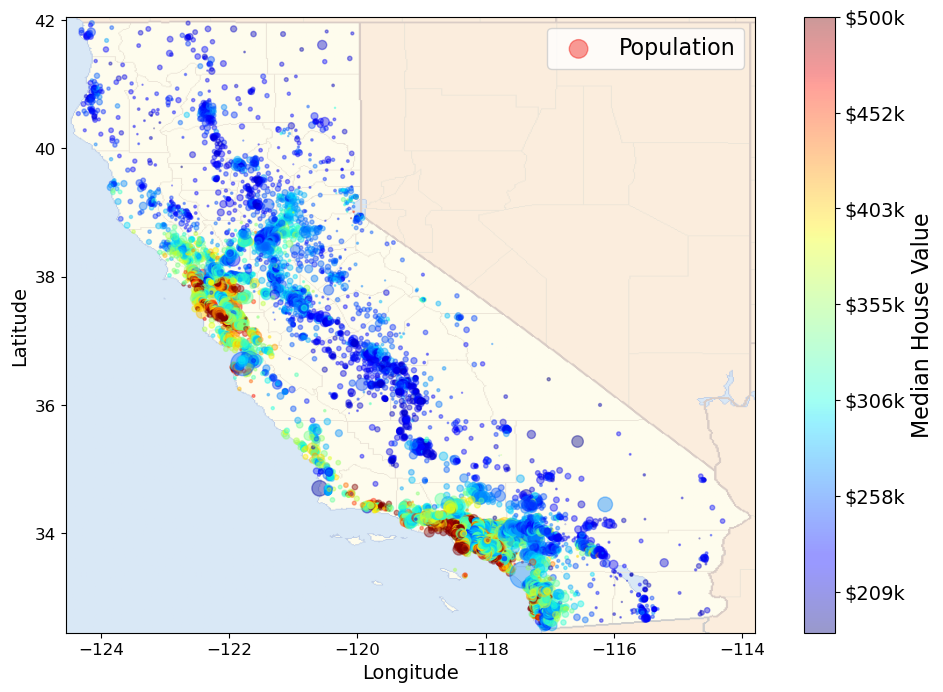

In [27]:
# load the image of the California map we just downloaded
california_img = mpimg.imread(os.path.join(images_path, filename))

# perform the plot we just did previously
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(12.5,8),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4,
                 )

# The following plots the map of california on the figure
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.4,
           cmap=plt.get_cmap("jet"))

# Make sure we have goo x and y axis labels
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

# change labels for the color bar so more human readable values in form $xxxk
prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)

# set color bar label
cbar.set_label('Median House Value', fontsize=16)

# set legend properties
plt.legend(fontsize=16);

# save this figure so we can put into presentations and reports
path = os.path.join(images_path, 'california-housing-prices.png')
plt.savefig(path);

### Looking for Correlations

The previous visualization was a bit of an aside.  Like I said, creating a figure like above
might be useful when exploring the data, though the more detail final figure is more like something
you would need for your final reporting.

Continuing on with our data exploration, after answering questions about the basic types,
distributions and presense of missing data, we might want to start doing some initial 
explorations of the feature attributes.  In particular, if we want to build a good 
model of the target label, we would like to know which features correlate most (and which least)
with our feature.

In this data set we want to build a model to predict the median house value of a district, 
given the feature attributes of the district.  So of the attributes we have in this data set,
we might ask, which one seem to be correlated with the `median_house_value`.

As a first step, we can use a _standard correlation coefficient_ (also known as a
_Pearson's correlation_) between every pair of attributes and our target label.

In [28]:
# computing standard correlation coefficient between every pair of attribute
housing_corr = housing.drop(['ocean_proximity'], axis='columns')
#corr_matrix = housing.corr() # Note, had to drop the categorical/string column which differs from text?
corr_matrix = housing_corr.corr()

# look at correlation of each attribution with the median_house_value attribute, sorted by descending correlation
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [29]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


Some basic background in statistics is useful here to fully understand what we are doing.
Here correlation can range from -1 to 1.  When it is close to 1 (a positive correlation) it means
that there is a strong linear correlation between the features.  This means that when one feature
increase, the other usually increases in some standard ratio.  A negative correlation, near to 
-1, means a correlation but in the opposite direction.  When one increases, the other decreases 
in some standard linear ratio.  A correlation of 0 means that there doesn't appear to be a 
relationship, when one increases, the other is as likely to increase or decrease or stay the 
same.

The raw numbers show that `median_income` is pretty correlated with house value (not unsurprising),
and `total_rooms` and `housing_median_age` might also be useful.  

Also notice a relatively high negative correlation to `latitude`.  Latitude measures the positon
from north to south on the California geographic location.  This is mostly because of the
south-heavy density of high value homes in the Los Angeles area in southern california.

As usual numbers can be useful, but humans are visual animals, so visualizing correlations can
sometimes be more useful.  There is a standard exploration plot in `pandas` that will 
create a grid of scatter plots between all numerical attributes of a `DataFrame`.  This will give 
you a visual sense of correlation of a pair of given attributes.  We have a few too many 
to plot all such scatter plot pairs, but we might want to visualize the most promising 
attributes.  The diagnols in such a matrix of correlation scatter plots would simply be straight 
lines, so by default `pandas` plots a histogram of the feature distribution instead.

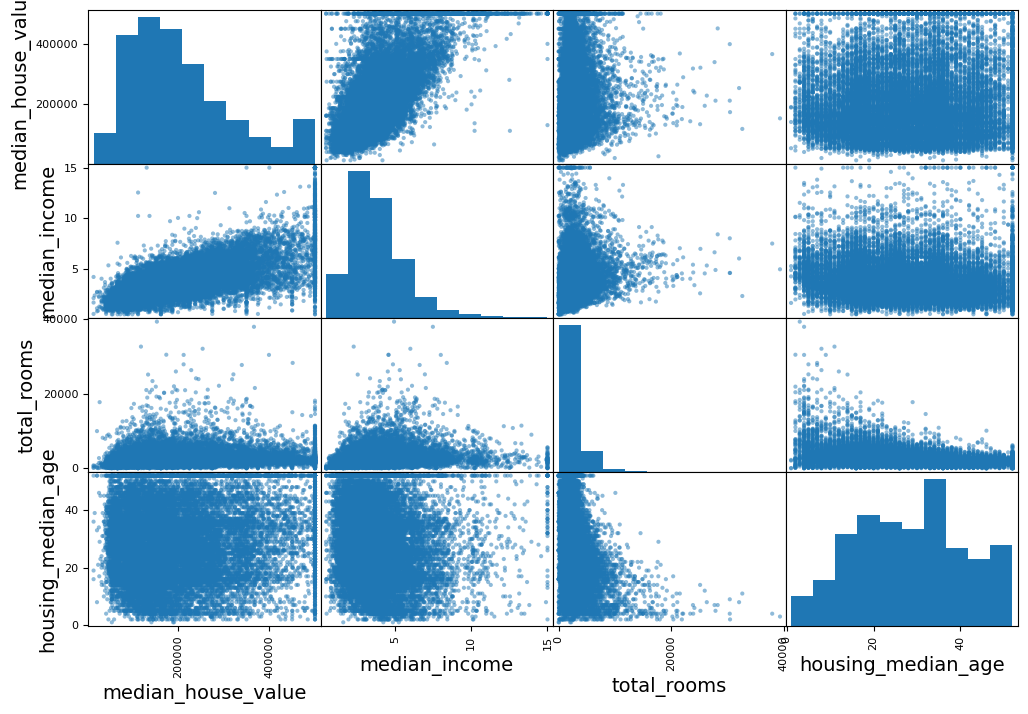

In [30]:
# visualizing correlations between a few of the attributes
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

scatter_matrix(housing[attributes], figsize=(12,8));

The take away from the above is you do see a fairly linear relationship between
`median_income` and `median_house_value` if you look at those pairs.  

This is the most promising correlation, so lets zoom in on the relationship between median 
income and the median house value.

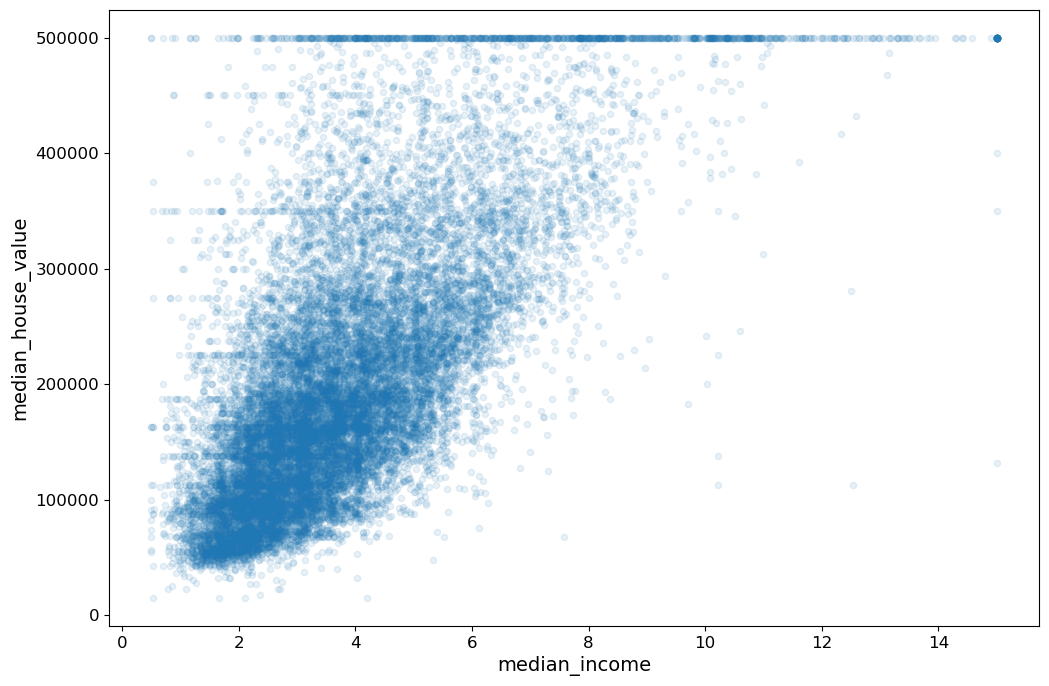

In [31]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, figsize=(12,8));

This polt reveals (to a trained idea) that the correlation is pretty strong, you can clearly see 
what looks like a linear upward trend.  Without the attribute cap, this correlation might be 
even stronger.  There seem to be some other horizontal lines at different prices points, which 
is interesting (notice how we are good at picking out such things).  These most likely 
represent us human preference for nice round numbers, thus settline on agreeing for prices 
like \\$450k or \\$350k for our final house price when buying or selling.

### Experimenting with Attribute Combinations

Finally it is often the case that a little feature engineering can cause significant 
improvements in our machine learning modeling.  It may not help much here, but from 
initial explorations of data like we have done, you can begin to ask questions and get a 
sense for what information might be useful for a model to learn to predict from, and if 
we can create this attribute with a clearer signal from existing data, or if we must instead 
go back to data collection if we would lik such a signal.

As discussed in the text, some of our features hide things that seem like they might 
be clearear (and better for a machine learning model) to learn from.  For example, 
we are given total rooms in the whole district, instead of the average number of rooms in each 
house in the district.  Likewise we are given `total_bedrooms` over the whole district.  These 
numbers will of course vary according to the number of `households` in the district.  They would 
be clearer if they were averages rather than absolute numbers.

The author does something slightly different for average number of rooms and average number 
of bedrooms.  I would probably have calculated these both in the same way, dividing both by 
the total number of households, to get the average rooms per household and the average 
bedrooms per household.  However the ratio of bedrooms to total rooms should give a
similar measure.  Just to prove this, I added a `bedrooms_per_household` as well to see the
correlations.

In [32]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_household'] = housing['total_bedrooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [33]:
# computing standard correlation coefficient between every pair of attribute
housing_corr = housing.drop(['ocean_proximity'], axis='columns')
# corr_matrix = housing.corr() # note had to drop the categorical/string attribute, differs from text?
corr_matrix = housing_corr.corr()

# look at correlation of each attribution with the median_house_value attribute, sorted by descending correlation
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
bedrooms_per_household     -0.046739
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

But my intuition turns out to be incorrect, which is a good lesson.  The `bedrooms_per_room` 
gives a much better signal here.  So the measures are not quite the same. The one propsed 
in the text is better, probably because it better captures differences in building number of
bedrooms.  I'm guessing that for more expensive houses you have lots of other types of rooms,
an office, an exercise room, an entertainment room, etc.